# Credit Card Fraud Detection

Anonymized credit card transactions labeled as fraudulent or genuine

Kaggle project hosted on https://www.kaggle.com/dalpozz/creditcardfraud

The datasets contains transactions made by credit cards in September 2013 by european cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. 

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

The dataset has been collected and analysed during a  research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

# Setting up
Import relevant packages and read dataset.

In [229]:
import pylab as py
import pandas as pd
import seaborn as sns
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.svm
import sklearn.naive_bayes
import sklearn.tree
import sklearn.neural_network
import sklearn.cluster
%matplotlib inline

In [2]:
dataset_filename = 'creditcard.csv'
dataset = pd.read_csv(dataset_filename)

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

# Checking data
It is said that features V1 to V28 are uncorrelated. I can check that this is true.

In [4]:
pca_which = [x[0]=='V' for x in dataset.columns]
covariance_matrix = dataset.cov()
covariance_pca = covariance_matrix.loc[pca_which,pca_which]
off_diagonal = covariance_pca - py.diag(py.diag(covariance_pca))
print('Maximum off-diagonal correlation coefficient is ',max(abs(off_diagonal.values.flatten())))

Maximum off-diagonal correlation coefficient is  2.27474416705e-14


Each PCA variable explain part of the variance observed in the dataset. I will now check the relative importance of each variable.

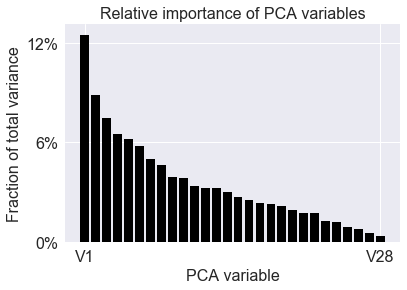

In [5]:
fig = py.figure()
ax = fig.add_subplot(111)
variances = py.diag(covariance_pca)
total_variance = sum(variances)
ax.bar(range(len(variances)),variances/total_variance,width=0.8,color='k')
ax.set_xticks([0,27])
ax.set_xticklabels(['V1','V28'],fontsize=16)
ax.set_xlabel('PCA variable',fontsize=16)
ax.set_yticks([0,0.06,0.12])
ax.set_yticklabels(['0%','6%','12%'],fontsize=16)
ax.set_ylabel('Fraction of total variance',fontsize=16)
ax.set_title('Relative importance of PCA variables',fontsize=16);

The first (most important) PCA variable explains about 12.5% of the variance in data, while the last (least important) variable explains about 0.3% of the variance in data. This does not justify discarding any of the variables.

# Which variables are highly correlated with fraud?
We can consider the strenght of correlation of each variable with the variable we are trying to predict.

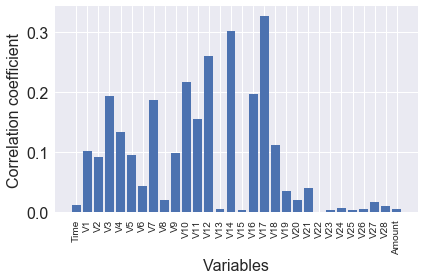

In [6]:
correlation_matrix = dataset.corr()
correlation_var = correlation_matrix.loc['Class',[x for x in correlation_matrix.columns if x!='Class']]
fig = py.figure()
ax = fig.add_subplot(111)
ax.bar(range(len(correlation_var)),abs(correlation_var),width=0.8)
ax.set_xticks(range(len(correlation_var)))
ax.set_xticklabels(correlation_var.index,rotation='vertical')
ax.set_xlabel('Variables',fontsize=16)
ax.set_ylabel('Correlation coefficient',fontsize=16)
ax.set_yticks([0,0.1,0.2,0.3])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16);
fig.tight_layout()

Some variables are highly correlated with the variable to predict. This is good news.

In [7]:
py.close('all')

# Data visualization
Since the data is already in PCA form, I can visualize them two-at-a-time.

In [8]:
def Data_Visualization(dataset,variableX,variableY,equal=True):
    dataset_valid = dataset[dataset['Class']==0]
    dataset_fraud = dataset[dataset['Class']==1]
    data_x_valid = dataset_valid[variableX]
    data_y_valid = dataset_valid[variableY]
    data_x_fraud = dataset_fraud[variableX]
    data_y_fraud = dataset_fraud[variableY]
    fig = py.figure()
    if equal:
        ax = fig.add_subplot(111,aspect='equal')
    else:
        ax = fig.add_subplot(111)
    ax.scatter(data_x_valid,data_y_valid,marker='.',color='k',label='Valid')
    ax.scatter(data_x_fraud,data_y_fraud,marker='*',color='r',label='Fraud')
    ax.set_xlabel(variableX,fontsize=16)
    ax.set_ylabel(variableY,fontsize=16)
    return fig,ax

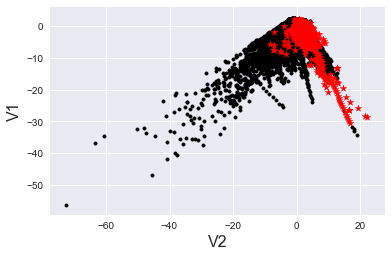

In [9]:
fig,ax = Data_Visualization(dataset,'V2','V1')

<IPython.core.display.Javascript object>


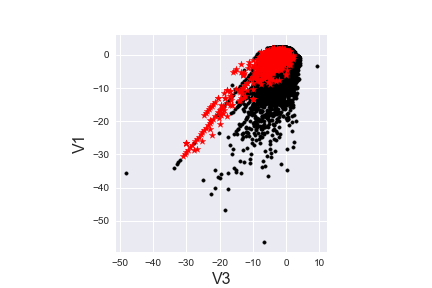

In [213]:
fig,ax = Data_Visualization(dataset,'V3','V1')

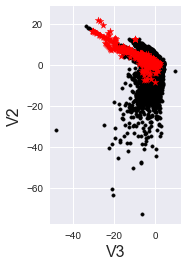

In [11]:
fig,ax = Data_Visualization(dataset,'V3','V2')

These plots are promising. It shows that the fraudulent transactions are concentrated and we can hope to find a rule that can separate them from the valid transactions. At the very least, we see that a simple model using only V1-V2-V3 can already flag many transactions as very likely to be non-fraudulent.

Variables V14 and V17 showed high correlation with the class variable.

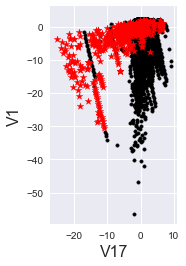

In [267]:
fig,ax = Data_Visualization(dataset,'V17','V1')

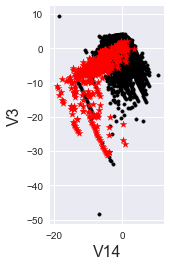

In [13]:
fig,ax = Data_Visualization(dataset,'V14','V3')

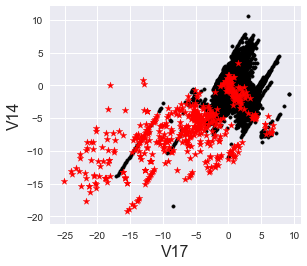

In [14]:
fig,ax = Data_Visualization(dataset,'V17','V14')

In [15]:
py.close('all')

# Dealing with time
The data includes two day's worth of transactions, labeled by seconds after the first transaction, which we don't know when it happened. From a histogram, we can infer that this transaction happened in the middle of the night, possibly at midnight of the relevant timezone.

In [16]:
dataset['Time_hours']  = dataset['Time'].apply(lambda x: x/(3600.))
print('Maximum of time variable is {:5.2f} hours'.format(max(dataset['Time_hours'])))

Maximum of time variable is 48.00 hours


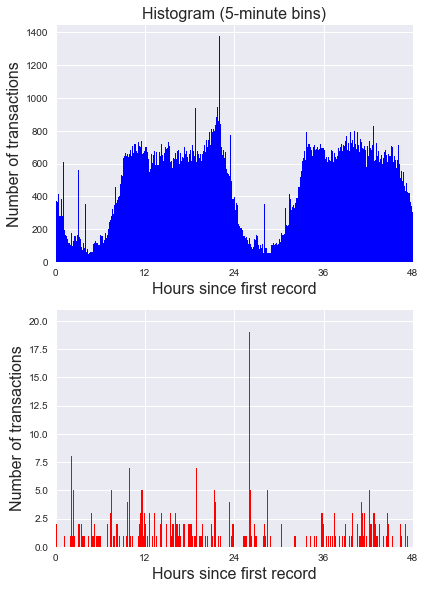

In [17]:
fig = py.figure(figsize=(1*6.4,2*4.8))
ax = fig.add_subplot(211)
n_bins = 48*12
hist_all_y,hist_all_x,_ = ax.hist(dataset[dataset['Class']==0]['Time_hours'],bins=n_bins,color='b',normed=None,range=(0,48));
ax.set_xlabel('Hours since first record',fontsize=16)
ax.set_ylabel('Number of transactions',fontsize=16);
ax.set_title('Histogram (5-minute bins)',fontsize=16)
ax.set_xticks([0,12,24,36,48])
ax.set_xlim([0,48]);
ax = fig.add_subplot(212)
hist_fraud_y,hist_fraud_x,_ = ax.hist(dataset[dataset['Class']==1]['Time_hours'],bins=n_bins,color='r',normed=None,range=(0,48));
ax.set_xlabel('Hours since first record',fontsize=16)
ax.set_ylabel('Number of transactions',fontsize=16);
ax.set_xticks([0,12,24,36,48])
ax.set_xlim([0,48]);

The histogram for all transactions show a clear pattern of day-night, even that the information is not fully present in the dataset. The histogram for fraudulent transactions, on the other hand, do not show quite the same pattern. This can be due to two reasons. One is that the sample size is small, only 500 fraudulent transactions. Another is that the frauds really do not obey the same day-night cycle as the legitimate transactions.

## Fourier variables

The influence of the transaction time on the probability of fraud has to be periodic with a period of 24 hours. Other cycles could be possible, such as a seven-day cycle to account for different weekday/weekend patterns, and possibly holidays. However, with only two days of data available, these cycles can not be studied. Because of that, I will consider, instead of the variable time, a set of Fourier coefficients for each transaction.

To check how many harmonics must be included, one can fit the time histogram with some number of harmonics.


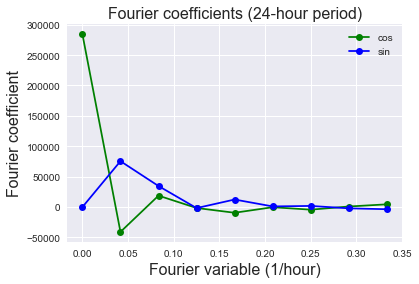

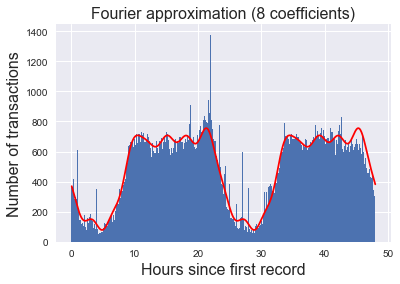

In [18]:
fourier_transform = py.rfft(hist_all_y)
n_coefficients = min(17,len(fourier_transform))

fig = py.figure()
ax = fig.add_subplot(111)
xx = py.rfftfreq(len(hist_all_y),48./len(hist_all_y))
ax.plot(xx[0:n_coefficients:2],py.real(fourier_transform)[0:n_coefficients:2],'go-',label='cos')
ax.plot(xx[0:n_coefficients:2],py.imag(fourier_transform)[0:n_coefficients:2],'bo-',label='sin')
ax.legend()
# ax.plot(xx[1:n_coefficients:2],abs(fourier_transform)[1:n_coefficients:2],'ro-')
ax.set_yscale('linear')
ax.set_xscale('linear')
ax.set_xlabel('Fourier variable (1/hour)',fontsize=16)
ax.set_ylabel('Fourier coefficient',fontsize=16)
ax.set_title('Fourier coefficients (24-hour period)',fontsize=16)

fig = py.figure()
ax = fig.add_subplot(111)
width = hist_all_x[1] - hist_all_x[0]
ax.bar(hist_all_x[:-1],hist_all_y,width=width)
fft = py.rfft(hist_all_y)
size = len(hist_all_y)
period = 48
reconstructed = py.array([fft[0].real / size for x in hist_all_x[1:]])
# n_coefficients = 48
for harmonics in range(2,min(len(fft),n_coefficients),2):
    reconstructed += py.array([fft[harmonics].real*py.cos(+harmonics * 2*py.pi*x/period)*2/size for x in hist_all_x[1:]])
    reconstructed += py.array([fft[harmonics].imag*py.sin(-harmonics * 2*py.pi*x/period)*2/size for x in hist_all_x[1:]])
ax.plot(hist_all_x[1:],reconstructed,'r-')
ax.set_xlabel('Hours since first record',fontsize=16)
ax.set_ylabel('Number of transactions',fontsize=16);
ax.set_title('Fourier approximation ({:d} coefficients)'.format(int(n_coefficients/2)),fontsize=16)




I will then add features that correspond to these harmonics (which tracks changes in a three-hour timescale)

In [19]:
# Creating Fourier variables with daily frequency
for column in dataset.columns:
    if 'Time_Fourier_Day' in column:
        dataset.drop(column,axis=1,inplace=True)
n_harmonics = 8
period = 24 * 60 * 60.0
for harmonic in range(1,1+n_harmonics):
    dataset['Time_Fourier_Day_C{:02d}'.format(harmonic)] = dataset['Time'].apply(lambda x,h=harmonic:py.cos(h*2*py.pi*x/period))
    dataset['Time_Fourier_Day_S{:02d}'.format(harmonic)] = dataset['Time'].apply(lambda x,h=harmonic:py.sin(h*2*py.pi*x/period))

In [20]:
py.close('all')

In [21]:
### By hand doing a probability of sucess 
fraction_of_frauds = [(t,y/x,py.sqrt(y)/x) if x!=0 else (t,py.nan) for x,y,t in zip(hist_all_y,hist_fraud_y,hist_all_x)]

<Container object of 3 artists>

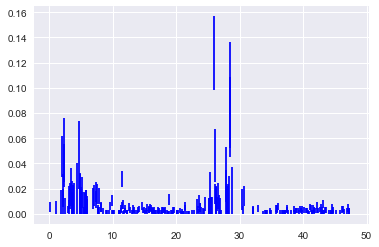

In [22]:
fig = py.figure()
ax = fig.add_subplot(111)
fraction_of_frauds = py.array(fraction_of_frauds).T
ax.errorbar(fraction_of_frauds[0],fraction_of_frauds[1],yerr=fraction_of_frauds[2],fmt='bx')

# View transaction amout
Like many money variables (that are constrained to be positive), the distribution of this variable is highly skewed with a long right tail. Because of that, it's best to consider the logarithm of the value.

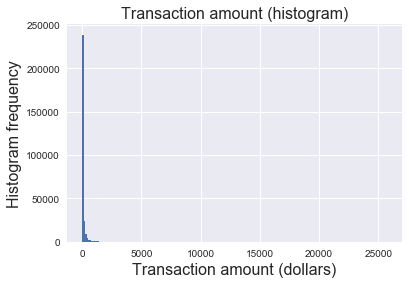

In [23]:
fig = py.figure()
ax = fig.add_subplot(111)
data_y = dataset['Amount']
ax.hist(data_y,bins=200);
ax.set_xlabel('Transaction amount (dollars)',fontsize=16)
ax.set_ylabel('Histogram frequency',fontsize=16)
ax.set_title('Transaction amount (histogram)',fontsize=16)

In [24]:
value_for_zero = py.log10(1e-3)
dataset['Amount_log'] = dataset['Amount'].apply(lambda x:py.log10(x) if x>0 else value_for_zero)

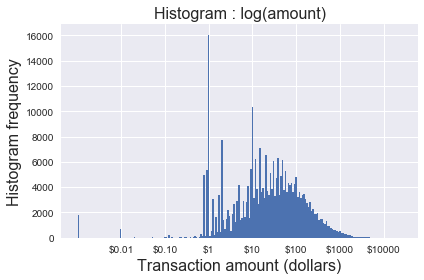

In [25]:
fig = py.figure()
ax = fig.add_subplot(111)
amount_log = py.array([x for x in dataset['Amount_log'] if not py.isnan(x)])
histogram_y,histogram_x,patches = ax.hist(amount_log,bins='auto');
ax.set_xlabel('Transaction amount (dollars)',fontsize=16)
ax.set_ylabel('Histogram frequency',fontsize=16)
ax.set_title('Histogram : log(amount)',fontsize=16);
ax.set_xticks(range(-2,5))
ax.set_xticklabels(['${:d}'.format(int(10.**x)) if x>=0 else '${:.02f}'.format(10.**x) for x in ax.get_xticks()]);
fig.tight_layout()

This histogram follows a Gaussian envelope with some spikes. To understand these spikes, it's instructive to look at the histogram of the cents part of the amount.

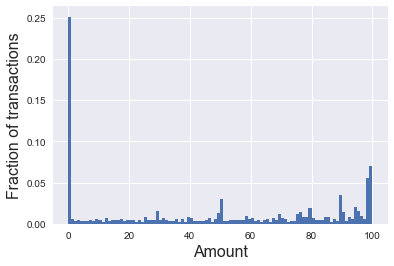

In [26]:
dataset['Amount_dollars'] = dataset['Amount'].apply(lambda x:int(x))
dataset['Amount_cents'] = dataset['Amount'].apply(lambda x:int(100*(x-int(x))))
fig = py.figure()
ax = fig.add_subplot(111)
hist_y,hist_x,_ = ax.hist(dataset['Amount_cents'],bins=100,range=(0,100),normed=1);
ax.set_xlabel('Amount',fontsize=16)
ax.set_ylabel('Fraction of transactions',fontsize=16)

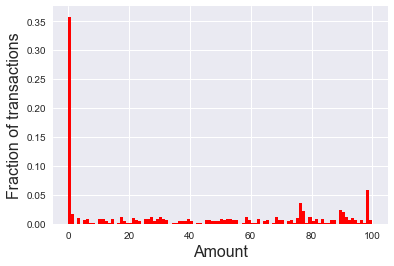

In [27]:
fig = py.figure()
ax = fig.add_subplot(111)
hist_y,hist_x,_ = ax.hist(dataset[dataset['Class']==1]['Amount_cents'],bins=100,range=(0,100),normed=1,color='r');
ax.set_xlabel('Amount',fontsize=16)
ax.set_ylabel('Fraction of transactions',fontsize=16)

Most transactions involve a whole-dollar amount. There is also some smaller peaks at almost-dollar (values ending in 0.90, 0.98 or 0.99) and also at 0.50. Then, I will create categorical variables to account for these conditions.

In [28]:
def categorizeCents(cents):
    if cents in [0]:
        return 'WholeDollar'
    elif cents in [50]:
        return 'HalfDollar'
    elif cents in [90,98,99]:
        return 'AlmostDollar'
    else:
        return 'Other'
dataset['Amount_centsCategory'] = dataset['Amount_cents'].apply(categorizeCents)

In [29]:
dataset['Amount_centsCategory'].value_counts()

Other           164555
WholeDollar      71516
AlmostDollar     40091
HalfDollar        8645
Name: Amount_centsCategory, dtype: int64

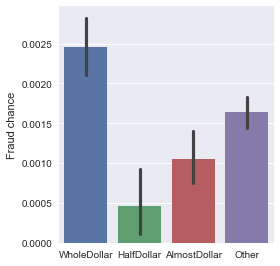

In [30]:
order = ['WholeDollar','HalfDollar','AlmostDollar','Other']
ax = sns.factorplot(x='Amount_centsCategory',y='Class',data=dataset,kind='bar',order=order)
ax.set_axis_labels('','Fraud chance')

Transactions with a whole amount of dollars seem to be more likely to be fraudulent than others.

In [31]:
py.close('all')

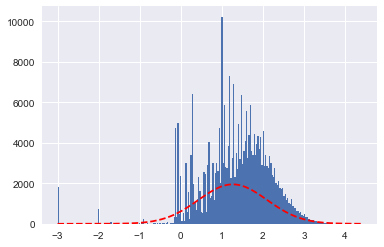

In [32]:
fig = py.figure()
ax = fig.add_subplot(111)
amount_log = py.array([x for x in dataset['Amount_log'] if not py.isnan(x) and x!=0])
histogram_y,histogram_x,patches = ax.hist(amount_log,bins='auto')
nonzeros = py.array([(x,y) for x,y in zip(histogram_x,histogram_y) if y>0])
poly_fitting = py.polyfit(nonzeros.T[0],py.log(nonzeros.T[1]),2)
histogram_y_fitted = py.exp(py.polyval(poly_fitting,histogram_x))
ax.plot(histogram_x,histogram_y_fitted,'r--')
ax.set_yscale('linear')

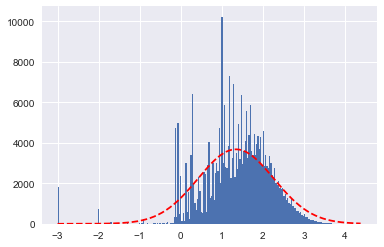

In [33]:
fig = py.figure()
ax = fig.add_subplot(111)
amount_log = py.array([x for x in dataset['Amount_log'] if not py.isnan(x) and x!=0])
histogram_y,histogram_x,patches = ax.hist(amount_log,bins='auto')
amount_log_mean = amount_log.mean()
amount_log_median = py.log10(dataset['Amount'].median())
amount_log_std = amount_log.std()
histogram_y_fitted = py.array(list(map(lambda x:py.exp(-(x-amount_log_median)**2/(2*amount_log_std)),histogram_x[:-1])))
histogram_y_fitted = histogram_y_fitted * sum(histogram_y) / sum(histogram_y_fitted)
ax.plot(histogram_x[:-1],histogram_y_fitted,'r--')
ax.set_yscale('linear')

In [34]:
amount_log_mean,amount_log_std

(1.3420281759247397, 0.85195584446410544)

In [35]:
10**(histogram_x[1+list(histogram_y).index(max(histogram_y))])

10.443973064961135

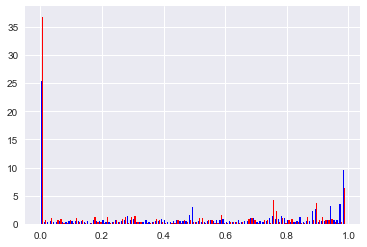

In [36]:
fig = py.figure()
ax = fig.add_subplot(111)
data_y = []
data_y.append([x%1 for x in dataset[dataset['Class']==0]['Amount']])
data_y.append([x%1 for x in dataset[dataset['Class']==1]['Amount']])
ax.hist(data_y,bins=99,color=['b','r'],normed=1);
# ax.hist([x%1 for x in dataset[dataset['Class']==1]['Amount']],bins=99,color='r',normed=True);

In [37]:
dataset['Amount'].median()

22.0

# Feature selection

In [38]:
features_pca = dataset[[x for x in dataset.columns if x[0]=='V']]
features_amount_cents = pd.get_dummies(dataset['Amount_centsCategory'],prefix='Amount_cents')
features_amount_cents = features_amount_cents.drop('Amount_cents_Other',axis=1)
features_amount = dataset[['Amount_log']]
features_time = dataset[[x for x in dataset.columns if 'Time_Fourier_Day' in x]]
features_label = dataset[['Class']]

In [39]:
datasets_selected = [features_pca,features_amount_cents,features_amount,features_time,features_label]
dataset_selected = datasets_selected[0]
for ds in datasets_selected[1:]:
    dataset_selected = dataset_selected.join(ds)

In [40]:
dataset_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 49 columns):
V1                           284807 non-null float64
V2                           284807 non-null float64
V3                           284807 non-null float64
V4                           284807 non-null float64
V5                           284807 non-null float64
V6                           284807 non-null float64
V7                           284807 non-null float64
V8                           284807 non-null float64
V9                           284807 non-null float64
V10                          284807 non-null float64
V11                          284807 non-null float64
V12                          284807 non-null float64
V13                          284807 non-null float64
V14                          284807 non-null float64
V15                          284807 non-null float64
V16                          284807 non-null float64
V17                          284807 non-n

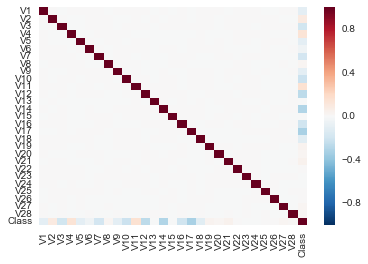

In [41]:
corr = features_pca.join(features_label).corr()
sns.heatmap(corr,xticklabels=True,yticklabels=True,vmax=1,vmin=-1)

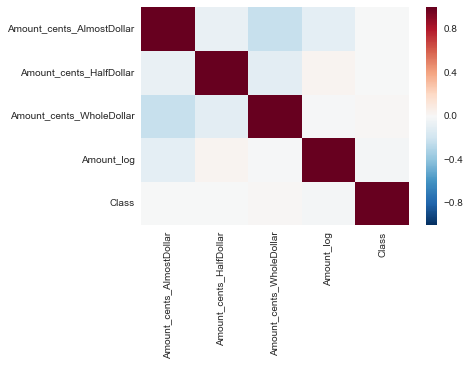

In [42]:
corr = features_amount_cents.join(features_amount).join(features_label).corr()
sns.heatmap(corr,xticklabels=True,yticklabels=True,vmax=1,vmin=-1)

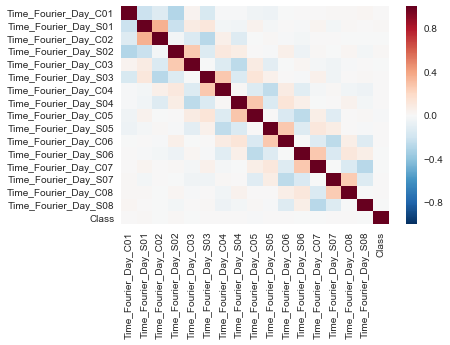

In [43]:
corr = features_time.join(features_label).corr()
sns.heatmap(corr,xticklabels=True,yticklabels=True,vmax=1,vmin=-1)

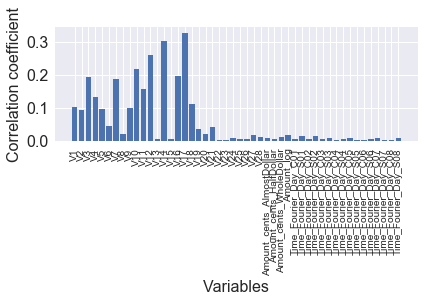

In [44]:
correlation_matrix = dataset_selected.corr()
correlation_var = correlation_matrix.loc['Class',[x for x in correlation_matrix.columns if x!='Class']]
fig = py.figure()
ax = fig.add_subplot(111)
ax.bar(range(len(correlation_var)),abs(correlation_var),width=0.8)
ax.set_xticks(range(len(correlation_var)))
ax.set_xticklabels(correlation_var.index,rotation='vertical')
ax.set_xlabel('Variables',fontsize=16)
ax.set_ylabel('Correlation coefficient',fontsize=16)
ax.set_yticks([0,0.1,0.2,0.3])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16);
fig.tight_layout()

In [45]:
py.close('all')

# Creating a train and test set
To avoid problems with overfitting, it's important to test a model in a different dataset than it was trained on.

In [46]:
dataset_train,dataset_test = sklearn.model_selection.train_test_split(dataset_selected,test_size=0.2,random_state=0)
features_train = dataset_train.drop('Class',axis=1)
features_test = dataset_test.drop('Class',axis=1)
class_train = dataset_train['Class']
class_test = dataset_test['Class']

In [47]:
py.close('all')

# Modeling the problem

I will test several models, and also potentially test a stacking model that combines some of the models. I will consider models that only take into account the PCA variables and models that take into account the other variables derived from Time and Amount. 

All models will be stored in the variable 'models' and the predicted probabilities are stored in a Pandas dataframe.

In [48]:
models = {}
predicted_probabilities = pd.DataFrame(index=dataset.index)

In [49]:
def plot_precision_recall_curve(y_true,prediction):
    fig = py.figure()
    ax = fig.add_subplot(111,aspect='equal')
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,prediction)
    ax.plot(recall,precision,'k.')
    ax.set_xlim(-0.1,1.1)
    ax.set_ylim(-0.1,1.1)
    ax.set_xticks([0,0.5,1.0])
    ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
    ax.set_yticks([0,0.5,1.0])
    ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
    ax.set_xlabel('Recall',fontsize=16)
    ax.set_ylabel('Precision',fontsize=16)
    return fig,ax

# A simple model - logistic regression

Before trying more 'fancy' models, I will look at a simple logistic regression, to serve as a benchmark. A simpler model of the logistic regression will actually only use the PCA variables.

In [50]:
estimator = sklearn.linear_model.LogisticRegression()
parameters = {'C':10**(py.linspace(-3,3,10))}
scoring = 'average_precision'
grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
columns_pca = [x for x in features_train.columns if x[0]=='V']
grid.fit(features_train[columns_pca],class_train)
label = 'logreg_pca'
models[label] = grid.best_estimator_
prediction = models[label].predict_proba(dataset_selected[columns_pca]).T[1]
predicted_probabilities = predicted_probabilities.join(pd.DataFrame(prediction,columns=[label]),lsuffix='',rsuffix='new')

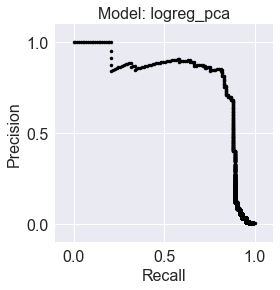

In [51]:
label = 'logreg_pca'
prediction = predicted_probabilities[label].loc[features_test.index]
fig,ax = plot_precision_recall_curve(class_test,prediction.T);
ax.set_title('Model: {:s}'.format(label),fontsize=16)

In [52]:
estimator = sklearn.linear_model.LogisticRegression()
parameters = {'C':10**(py.linspace(-3,3,10))}
scoring = 'average_precision'
grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
columns_all = [x for x in features_train.columns]
grid.fit(features_train[columns_all],class_train)
label = 'logreg_all'
models[label] = grid.best_estimator_
prediction = models[label].predict_proba(dataset_selected[columns_all]).T[1]
predicted_probabilities = predicted_probabilities.join(pd.DataFrame(prediction,columns=[label]),lsuffix='',rsuffix='new')

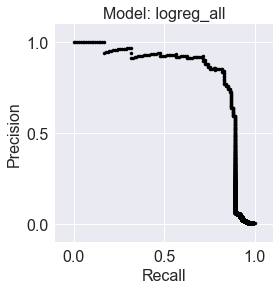

In [53]:
label = 'logreg_all'
prediction = predicted_probabilities[label].loc[features_test.index]
fig,ax = plot_precision_recall_curve(class_test,prediction.T);
ax.set_title('Model: {:s}'.format(label),fontsize=16)

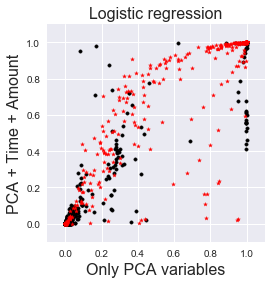

In [54]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
xx = predicted_probabilities[dataset['Class']==0]['logreg_pca']
yy = predicted_probabilities[dataset['Class']==0]['logreg_all']
ax.scatter(xx,yy,s=12,marker='o',color='k')
xx = predicted_probabilities[dataset['Class']==1]['logreg_pca']
yy = predicted_probabilities[dataset['Class']==1]['logreg_all']
ax.scatter(xx,yy,s=16,marker='*',color='r')
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xlabel('Only PCA variables',fontsize=16)
ax.set_ylabel('PCA + Time + Amount',fontsize=16)
ax.set_title('Logistic regression',fontsize=16)

In [55]:
predicted_probabilities.corr()

,logreg_pca,logreg_all
logreg_pca,1.000000,0.965982
logreg_all,0.965982,1.000000


Optimal F1 score : 0.834


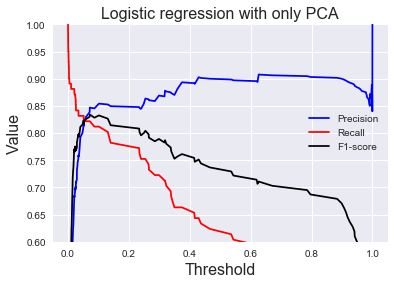

In [56]:
label = 'logreg_pca'
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,predicted_probabilities[label].loc[class_test.index])
prt = py.array([(x,y,z) for x,y,z in zip(precision,recall,threshold) if z>0.00 and z<1])
fig = py.figure()
ax = fig.add_subplot(111)
ax.plot(prt.T[2],prt.T[0],'b-',label='Precision')
ax.plot(prt.T[2],prt.T[1],'r-',label='Recall')
f1 = [(2*x[0]*x[1]/(x[0]+x[1])) for x in prt]
ax.plot(prt.T[2],f1,'k-',label='F1-score')
ax.set_xlabel('Threshold',fontsize=16)
ax.set_ylabel('Value',fontsize=16)
ax.set_title('Logistic regression with only PCA',fontsize=16)
ax.legend(loc='center right')
ax.set_ylim(0.6,1.0)
print('Optimal F1 score : {:5.3f}'.format(max(f1)))

Optimal FBeta score : 0.877
Precision at optimal point: 0.685
Recall at optimal point: 0.881


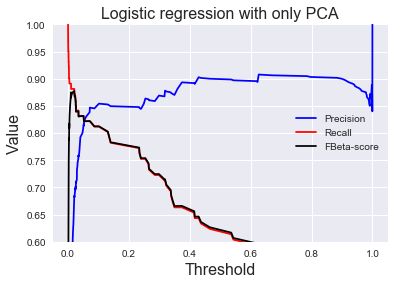

In [57]:
label = 'logreg_pca'
beta = 8
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,predicted_probabilities[label].loc[class_test.index])
prt = py.array([(x,y,z) for x,y,z in zip(precision,recall,threshold) if z>0.00 and z<1])
fig = py.figure()
ax = fig.add_subplot(111)
ax.plot(prt.T[2],prt.T[0],'b-',label='Precision')
ax.plot(prt.T[2],prt.T[1],'r-',label='Recall')
fbeta = [((1+beta**2)*x[0]*x[1]/(beta**2*x[0]+x[1])) for x in prt]
ax.plot(prt.T[2],fbeta,'k-',label='FBeta-score')
ax.set_xlabel('Threshold',fontsize=16)
ax.set_ylabel('Value',fontsize=16)
ax.set_title('Logistic regression with only PCA',fontsize=16)
ax.legend(loc='center right')
ax.set_ylim(0.6,1.0)
print('Optimal FBeta score : {:5.3f}'.format(max(fbeta)))
print('Precision at optimal point: {:5.3f}'.format(precision[fbeta.index(max(fbeta))]))
print('Recall at optimal point: {:5.3f}'.format(recall[fbeta.index(max(fbeta))]))

Optimal F1 score : 0.838
Precision at optimal point: 0.856
Recall at optimal point: 0.822


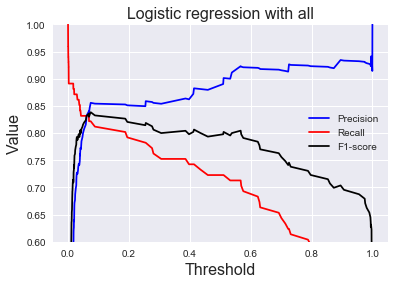

In [58]:
label = 'logreg_all'
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,predicted_probabilities[label].loc[class_test.index])
prt = py.array([(x,y,z) for x,y,z in zip(precision,recall,threshold) if z>0.00 and z<1])
fig = py.figure()
ax = fig.add_subplot(111)
ax.plot(prt.T[2],prt.T[0],'b-',label='Precision')
ax.plot(prt.T[2],prt.T[1],'r-',label='Recall')
f1 = [(2*x[0]*x[1]/(x[0]+x[1])) for x in prt]
ax.plot(prt.T[2],f1,'k-',label='F1-score')
ax.set_xlabel('Threshold',fontsize=16)
ax.set_ylabel('Value',fontsize=16)
ax.set_title('Logistic regression with all',fontsize=16)
ax.legend(loc='center right')
ax.set_ylim(0.6,1.0)
print('Optimal F1 score : {:5.3f}'.format(max(f1)))
print('Precision at optimal point: {:5.3f}'.format(precision[f1.index(max(f1))]))
print('Recall at optimal point: {:5.3f}'.format(recall[f1.index(max(f1))]))

Optimal FBeta score : 0.874
Precision at optimal point: 0.596
Recall at optimal point: 0.891


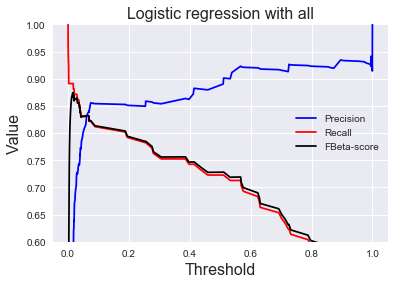

In [59]:
label = 'logreg_all'
beta = 5
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,predicted_probabilities[label].loc[class_test.index])
prt = py.array([(x,y,z) for x,y,z in zip(precision,recall,threshold) if z>0.00 and z<1])
fig = py.figure()
ax = fig.add_subplot(111)
ax.plot(prt.T[2],prt.T[0],'b-',label='Precision')
ax.plot(prt.T[2],prt.T[1],'r-',label='Recall')
fbeta = [((1+beta**2)*x[0]*x[1]/(beta**2*x[0]+x[1])) for x in prt]
ax.plot(prt.T[2],fbeta,'k-',label='FBeta-score')
ax.set_xlabel('Threshold',fontsize=16)
ax.set_ylabel('Value',fontsize=16)
ax.set_title('Logistic regression with all',fontsize=16)
ax.legend(loc='center right')
ax.set_ylim(0.6,1.0)
print('Optimal FBeta score : {:5.3f}'.format(max(fbeta)))
print('Precision at optimal point: {:5.3f}'.format(precision[fbeta.index(max(fbeta))]))
print('Recall at optimal point: {:5.3f}'.format(recall[fbeta.index(max(fbeta))]))

In the benchmark provided by the logistic regression method, using the variables derived from Time and Amount led to a small gain in predictive power. 

In the context of credit card fraud, a type-II error (false negative) brings more potential trouble than a type-I error (false positive), and so recall is more important than precision. Then, $F_1$-score is not a good metric, but $F_{\beta}$-score can be, where $\beta$ represents the importance of recall relative to precision. In the last plot, I optimized $F_{\beta}$ with $\beta = 10$, even though the result did not change much in the range from $\beta = 5$ to $\beta = 30$. The result of this graph shows that it's possible to reach around 89% recall with about 60% precision, all with a simple logistic regression model.

In the even simpler model of logistic regression using only the PCA variables, it's possible to reach 89% recall with 41% precision, or 88% recall with 68% precision. Which of these situations is preferred depends on the relative importance given to a type-I or type-II error.

# Naive Bayes method

I am now going to test another very simple model, that is very fast computationally.

In [60]:
estimator = sklearn.naive_bayes.GaussianNB()
parameters = {}
scoring = 'average_precision'
grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
columns_pca = [x for x in features_train.columns if x[0]=='V']
grid.fit(features_train[columns_pca],class_train)
label = 'naivebayes_pca'
models[label] = grid.best_estimator_
prediction = models[label].predict_proba(dataset_selected[columns_pca]).T[1]
predicted_probabilities = predicted_probabilities.join(pd.DataFrame(prediction,columns=[label]),lsuffix='',rsuffix='new')

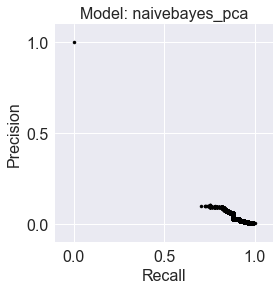

In [61]:
label = 'naivebayes_pca'
prediction = predicted_probabilities[label].loc[features_test.index]
fig,ax = plot_precision_recall_curve(class_test,prediction.T);
ax.set_title('Model: {:s}'.format(label),fontsize=16)

In [62]:
estimator = sklearn.naive_bayes.GaussianNB()
parameters = {}
scoring = 'average_precision'
grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
columns_all = [x for x in features_train.columns]
grid.fit(features_train[columns_all],class_train)
label = 'naivebayes_all'
models[label] = grid.best_estimator_
prediction = models[label].predict_proba(dataset_selected[columns_all]).T[1]
predicted_probabilities = predicted_probabilities.join(pd.DataFrame(prediction,columns=[label]),lsuffix='',rsuffix='new')

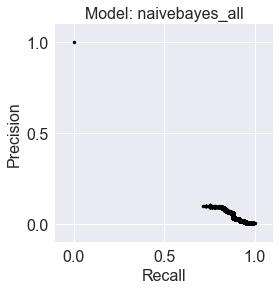

In [63]:
label = 'naivebayes_all'
prediction = predicted_probabilities[label].loc[features_test.index]
fig,ax = plot_precision_recall_curve(class_test,prediction.T);
ax.set_title('Model: {:s}'.format(label),fontsize=16)

It is a very naive method, not much helpful.

In [64]:
predicted_probabilities.corr()

,logreg_pca,logreg_all,naivebayes_pca,naivebayes_all
logreg_pca,1.000000,0.965982,0.255047,0.254378
logreg_all,0.965982,1.000000,0.259342,0.258764
naivebayes_pca,0.255047,0.259342,1.000000,0.992844
naivebayes_all,0.254378,0.258764,0.992844,1.000000


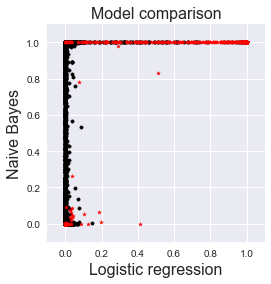

In [65]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
xx = predicted_probabilities[dataset['Class']==0]['logreg_all']
yy = predicted_probabilities[dataset['Class']==0]['naivebayes_all']
ax.scatter(xx,yy,s=12,marker='o',color='k')
xx = predicted_probabilities[dataset['Class']==1]['logreg_all']
yy = predicted_probabilities[dataset['Class']==1]['naivebayes_all']
ax.scatter(xx,yy,s=16,marker='*',color='r')
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xlabel('Logistic regression',fontsize=16)
ax.set_ylabel('Naive Bayes',fontsize=16)
ax.set_title('Model comparison',fontsize=16)

# Decision tree classifier

In [66]:
label = 'tree_gini_pca'
models[label] = sklearn.tree.DecisionTreeClassifier(criterion = 'gini')
models[label].fit(features_train[columns_pca],class_train)
prediction = models[label].predict_proba(dataset_selected[columns_pca]).T[1]
predicted_probabilities = predicted_probabilities.join(pd.DataFrame(prediction,columns=[label]),lsuffix='',rsuffix='new')

In [67]:
label = 'tree_gini_all'
models[label] = sklearn.tree.DecisionTreeClassifier(criterion = 'gini')
models[label].fit(features_train[columns_all],class_train)
prediction = models[label].predict_proba(dataset_selected[columns_all]).T[1]
predicted_probabilities = predicted_probabilities.join(pd.DataFrame(prediction,columns=[label]),lsuffix='',rsuffix='new')

In [68]:
label = 'tree_entropy_pca'
models[label] = sklearn.tree.DecisionTreeClassifier(criterion = 'entropy')
models[label].fit(features_train[columns_pca],class_train)
prediction = models[label].predict_proba(dataset_selected[columns_pca]).T[1]
predicted_probabilities = predicted_probabilities.join(pd.DataFrame(prediction,columns=[label]),lsuffix='',rsuffix='new')

In [69]:
label = 'tree_entropy_all'
models[label] = sklearn.tree.DecisionTreeClassifier(criterion = 'gini')
models[label].fit(features_train[columns_all],class_train)
prediction = models[label].predict_proba(dataset_selected[columns_all]).T[1]
predicted_probabilities = predicted_probabilities.join(pd.DataFrame(prediction,columns=[label]),lsuffix='',rsuffix='new')

In [303]:
help(sklearn.tree.DecisionTreeClassifier())

Help on DecisionTreeClassifier in module sklearn.tree.tree object:

class DecisionTreeClassifier(BaseDecisionTree, sklearn.base.ClassifierMixin)
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : string, optional (default="best")
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.
 |  
 |  max_features : int, float, string or None, optional (default=None)
 |      The number of features to consider when looking for the best split:
 |  
 |          - If int, then consider `max_features` features at each split.
 |          - If float, then `max_features` is a percentage and
 

# Support vector machine (may take a long time)

In [91]:
label = 'svc_linear_all'
models[label] = sklearn.svm.LinearSVC()
models[label].fit(features_train[columns_all],class_train)
prediction = models[label].predict(dataset_selected[columns_all])
predicted_probabilities = predicted_probabilities.join(pd.DataFrame(prediction,columns=[label]),lsuffix='',rsuffix='new')

In [92]:
label = 'svc_general_all'
models[label] = sklearn.svm.SVC()
models[label].fit(features_train[columns_all],class_train)
prediction = models[label].predict(dataset_selected[columns_all])
predicted_probabilities = predicted_probabilities.join(pd.DataFrame(prediction,columns=[label]),lsuffix='',rsuffix='new')

# Neural networks

In [108]:
estimator = sklearn.neural_network.MLPClassifier()
parameters = {'activation':['relu','tanh','logistic'],'alpha':10**(py.linspace(-5,-3,3))}
scoring = 'average_precision'
grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
grid.fit(features_train[columns_pca],class_train)
label = 'neuralnet_pca'
models[label] = grid.best_estimator_
prediction = models[label].predict_proba(dataset_selected[columns_pca]).T[1]
predicted_probabilities = predicted_probabilities.join(pd.DataFrame(prediction,columns=[label]),lsuffix='',rsuffix='new')

In [111]:
estimator = sklearn.neural_network.MLPClassifier()
parameters = {'activation':['relu','tanh','logistic'],'alpha':10**(py.linspace(-5,-3,3))}
scoring = 'average_precision'
grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
grid.fit(features_train[columns_all],class_train)
label = 'neuralnet_all'
models[label] = grid.best_estimator_
prediction = models[label].predict_proba(dataset_selected[columns_all]).T[1]
predicted_probabilities = predicted_probabilities.join(pd.DataFrame(prediction,columns=[label]),lsuffix='',rsuffix='new')

In [123]:
estimator = sklearn.neural_network.MLPClassifier()
parameters = {'activation':['relu','tanh','logistic'],'alpha':10**(py.linspace(-5,-3,3)),'hidden_layer_sizes':[(200,),(300,),(500,)]}
scoring = 'average_precision'
grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
grid.fit(features_train[columns_pca],class_train)
label = 'neuralnet_large_pca'
models[label] = grid.best_estimator_
prediction = models[label].predict_proba(dataset_selected[columns_pca]).T[1]
predicted_probabilities = predicted_probabilities.join(pd.DataFrame(prediction,columns=[label]),lsuffix='',rsuffix='new')

In [124]:
estimator = sklearn.neural_network.MLPClassifier()
parameters = {'activation':['relu','tanh','logistic'],'alpha':10**(py.linspace(-5,-3,3)),'hidden_layer_sizes':[(200,),(300,),(500,)]}
scoring = 'average_precision'
grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
grid.fit(features_train[columns_all],class_train)
label = 'neuralnet_large_all'
models[label] = grid.best_estimator_
prediction = models[label].predict_proba(dataset_selected[columns_all]).T[1]
predicted_probabilities = predicted_probabilities.join(pd.DataFrame(prediction,columns=[label]),lsuffix='',rsuffix='new')

# Comparing precision-recall curves


<IPython.core.display.Javascript object>


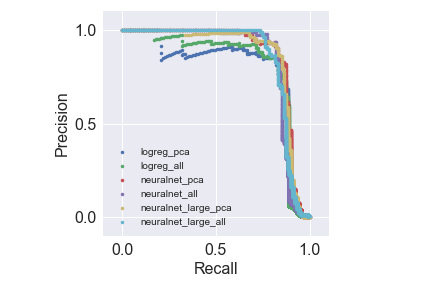

In [131]:
%matplotlib notebook
%matplotlib notebook

which_models = ['logreg_pca','logreg_all','neuralnet_pca','neuralnet_all','neuralnet_large_pca','neuralnet_large_all']
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
for label in predicted_probabilities.columns:
    if label in which_models:
        prediction = predicted_probabilities[label].loc[class_test.index]
        precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,prediction)
        ax.plot(recall,precision,'.',label=label)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.legend(loc='lower left')
fig.tight_layout();

<IPython.core.display.Javascript object>


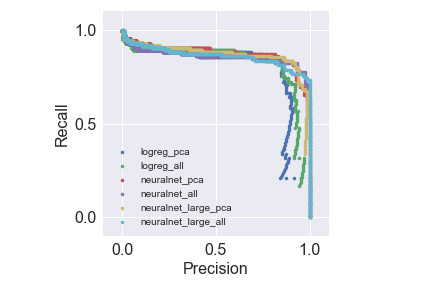

In [147]:
%matplotlib notebook
%matplotlib notebook

which_models = ['logreg_pca','logreg_all','neuralnet_pca','neuralnet_all','neuralnet_large_pca','neuralnet_large_all']
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
for label in predicted_probabilities.columns:
    if label in which_models:
        prediction = predicted_probabilities[label].loc[class_test.index]
        precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,prediction)
        ax.plot(precision,recall,'.',label=label)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_ylabel('Recall',fontsize=16)
ax.set_xlabel('Precision',fontsize=16)
ax.legend(loc='lower left')
fig.tight_layout();

<IPython.core.display.Javascript object>


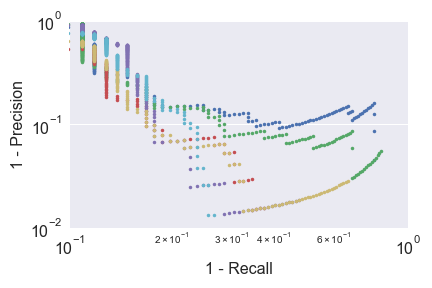

In [146]:
%matplotlib notebook
%matplotlib notebook

which_models = ['logreg_pca','logreg_all','neuralnet_pca','neuralnet_all','neuralnet_large_pca','neuralnet_large_all']
fig = py.figure()
ax = fig.add_subplot(111)
for label in predicted_probabilities.columns:
    if label in which_models:
        prediction = predicted_probabilities[label].loc[class_test.index]
        precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,prediction)
        ax.plot(1-recall,1-precision,'.',label=label)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_xlabel('1 - Recall',fontsize=16)
ax.set_ylabel('1 - Precision',fontsize=16)
# ax.legend(loc='upper left')
ax.set_xscale('log')
ax.set_xlim(1e-1,1)
ax.set_yscale('log')
ax.set_ylim(1e-2,1)

fig.tight_layout();

In [132]:
print(models['neuralnet_large_pca'])
print(models['neuralnet_large_all'])



MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(300,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
MLPClassifier(activation='tanh', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(300,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


Optimal FBeta score : 0.870
Precision at optimal point: 0.467
Recall at optimal point: 0.901


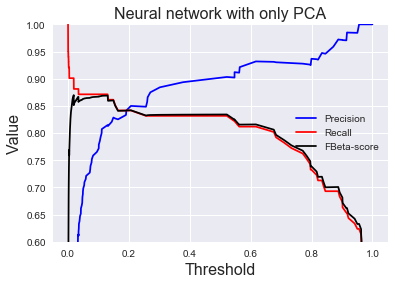

In [119]:
label = 'neuralnet_pca'
beta = 5
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,predicted_probabilities[label].loc[class_test.index])
prt = py.array([(x,y,z) for x,y,z in zip(precision,recall,threshold) if z>0.00 and z<1])
fig = py.figure()
ax = fig.add_subplot(111)
ax.plot(prt.T[2],prt.T[0],'b-',label='Precision')
ax.plot(prt.T[2],prt.T[1],'r-',label='Recall')
fbeta = [((1+beta**2)*x[0]*x[1]/(beta**2*x[0]+x[1])) for x in prt]
ax.plot(prt.T[2],fbeta,'k-',label='FBeta-score')
ax.set_xlabel('Threshold',fontsize=16)
ax.set_ylabel('Value',fontsize=16)
ax.set_title('Neural network with only PCA',fontsize=16)
ax.legend(loc='center right')
ax.set_ylim(0.6,1.0)
print('Optimal FBeta score : {:5.3f}'.format(max(fbeta)))
print('Precision at optimal point: {:5.3f}'.format(precision[fbeta.index(max(fbeta))]))
print('Recall at optimal point: {:5.3f}'.format(recall[fbeta.index(max(fbeta))]))

Optimal FBeta score : 0.844
Precision at optimal point: 0.694
Recall at optimal point: 0.851


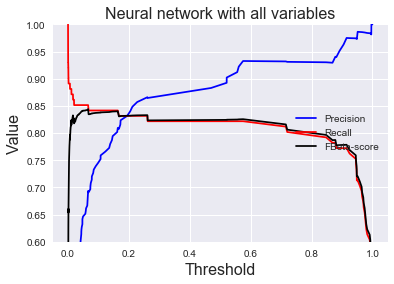

In [120]:
label = 'neuralnet_all'
beta = 5
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,predicted_probabilities[label].loc[class_test.index])
prt = py.array([(x,y,z) for x,y,z in zip(precision,recall,threshold) if z>0.00 and z<1])
fig = py.figure()
ax = fig.add_subplot(111)
ax.plot(prt.T[2],prt.T[0],'b-',label='Precision')
ax.plot(prt.T[2],prt.T[1],'r-',label='Recall')
fbeta = [((1+beta**2)*x[0]*x[1]/(beta**2*x[0]+x[1])) for x in prt]
ax.plot(prt.T[2],fbeta,'k-',label='FBeta-score')
ax.set_xlabel('Threshold',fontsize=16)
ax.set_ylabel('Value',fontsize=16)
ax.set_title('Neural network with all variables',fontsize=16)
ax.legend(loc='center right')
ax.set_ylim(0.6,1.0)
print('Optimal FBeta score : {:5.3f}'.format(max(fbeta)))
print('Precision at optimal point: {:5.3f}'.format(precision[fbeta.index(max(fbeta))]))
print('Recall at optimal point: {:5.3f}'.format(recall[fbeta.index(max(fbeta))]))

In [148]:
auc_score = {}
for label in predicted_probabilities.columns:
    prediction = predicted_probabilities[label].loc[class_test.index]
    score = sklearn.metrics.average_precision_score(class_test,prediction)
    auc_score[label] = score

# Stacking
I will now consider a meta-model

In [157]:
stacking_model = sklearn.linear_model.LogisticRegression()
stacking_train = predicted_probabilities.loc[features_train.index]
stacking_model.fit(stacking_train,class_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

<IPython.core.display.Javascript object>


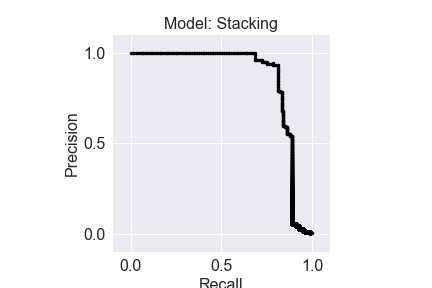

In [164]:
prediction = stacking_model.predict_proba(predicted_probabilities.loc[features_test.index]).T[1]
fig,ax = plot_precision_recall_curve(class_test,prediction);
ax.set_title('Model: {:s}'.format('Stacking'),fontsize=16)

<IPython.core.display.Javascript object>


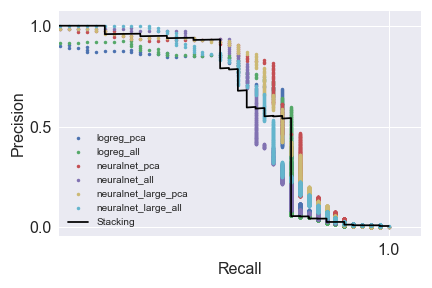

In [198]:
which_models = ['logreg_pca','logreg_all','neuralnet_pca','neuralnet_all','neuralnet_large_pca','neuralnet_large_all']
fig = py.figure()
ax = fig.add_subplot(111)
for label in predicted_probabilities.columns:
    if label in which_models:
        prediction = predicted_probabilities[label].loc[class_test.index]
        precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,prediction)
        ax.plot(recall,precision,'.',label=label)
prediction = stacking_model.predict_proba(predicted_probabilities.loc[features_test.index]).T[1]
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,prediction)
ax.plot(recall,precision,'k-',label='Stacking')



ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.legend(loc='lower left')
fig.tight_layout();

In [168]:
for label,value in zip(models,stacking_model.coef_[0]):
    print('{:30s} {:5.3f}'.format(label,value))

logreg_pca                     0.233
logreg_all                     0.259
naivebayes_pca                 0.095
naivebayes_all                 0.096
tree_gini_pca                  3.114
tree_gini_all                  3.114
tree_entropy_pca               3.114
tree_entropy_all               3.114
svc_linear_all                 0.173
svc_general_all                0.358
neuralnet_pca                  0.452
neuralnet_all                  0.970
neuralnet_large_pca            0.499
neuralnet_large_all            0.460


<IPython.core.display.Javascript object>


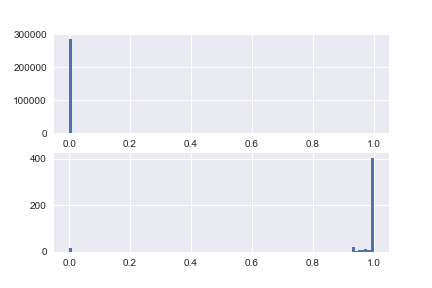

In [183]:
prediction = [(x,y) for x,y in zip(dataset['Class'],stacking_model.predict_proba(predicted_probabilities).T[1])]
fig = py.figure()
ax = fig.add_subplot(211)
hist_y,hist_x,_ = ax.hist([y for x,y in prediction if x==0],bins=100,range=(0,1))
ax = fig.add_subplot(212)
hist_y,hist_x,_ = ax.hist([y for x,y in prediction if x==1],bins=100,range=(0,1))

<IPython.core.display.Javascript object>


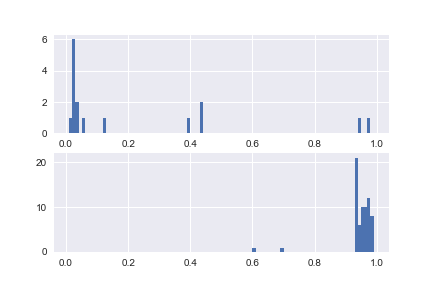

In [187]:
fig = py.figure()
ax = fig.add_subplot(211)
hist_y,hist_x,_ = ax.hist([y for x,y in prediction if x==0],bins=98,range=(0.01,0.99))
ax = fig.add_subplot(212)
hist_y,hist_x,_ = ax.hist([y for x,y in prediction if x==1],bins=98,range=(0.01,0.99))

<IPython.core.display.Javascript object>


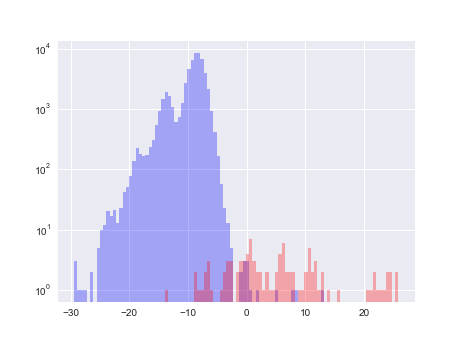

In [227]:
model_label = 'logreg_all'
# prediction = [(x,y) for x,y in zip(dataset_selected['Class'],models['neuralnet_large_all'].predict_proba(dataset_selected.drop('Class',axis=1)).T[1])]
prediction = [(x,y) for x,y in zip(class_test,models[model_label].predict_proba(features_test).T[1])]
logodds = [(x,py.log(y) - py.log(1.-y)) for x,y in prediction]
minn = min([y for x,y in logodds])
maxx = max([y for x,y in logodds])
fig = py.figure(figsize=(6.4,1*4.8))
ax = fig.add_subplot(111)
hist_y,hist_x,_ = ax.hist([y for x,y in logodds if x==0],bins=100,range=(minn,maxx),color='b',alpha=0.3)
ax.set_yscale('linear')
# ax = fig.add_subplot(212)
hist_y,hist_x,_ = ax.hist([y for x,y in logodds if x==1],bins=100,range=(minn,maxx),color='r',alpha=0.3)
ax.set_yscale('log')

<IPython.core.display.Javascript object>


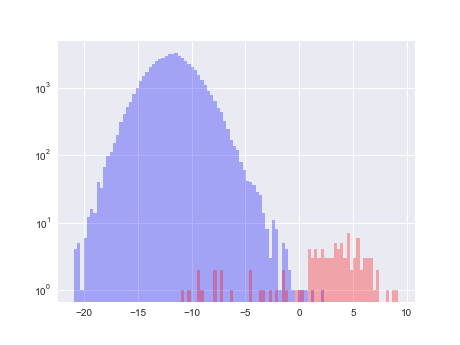

In [226]:
model_label = 'neuralnet_large_all'
# prediction = [(x,y) for x,y in zip(dataset_selected['Class'],models['neuralnet_large_all'].predict_proba(dataset_selected.drop('Class',axis=1)).T[1])]
prediction = [(x,y) for x,y in zip(class_test,models[model_label].predict_proba(features_test).T[1])]
logodds = [(x,py.log(y) - py.log(1.-y)) for x,y in prediction]
minn = min([y for x,y in logodds])
maxx = max([y for x,y in logodds])
fig = py.figure(figsize=(6.4,1*4.8))
ax = fig.add_subplot(111)
hist_y,hist_x,_ = ax.hist([y for x,y in logodds if x==0],bins=100,range=(minn,maxx),color='b',alpha=0.3)
ax.set_yscale('linear')
# ax = fig.add_subplot(212)
hist_y,hist_x,_ = ax.hist([y for x,y in logodds if x==1],bins=100,range=(minn,maxx),color='r',alpha=0.3)
ax.set_yscale('log')

<IPython.core.display.Javascript object>


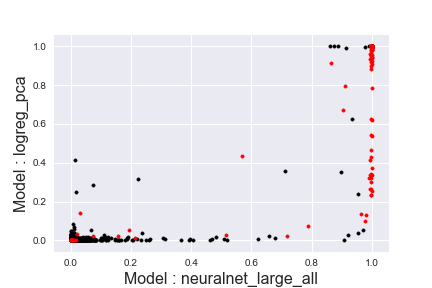

In [208]:
fig,ax = py.subplots()
xlabel = 'neuralnet_large_all'
ylabel = 'logreg_pca'
test_zero = class_test[class_test==0].index
xx = predicted_probabilities.loc[test_zero,xlabel]
yy = predicted_probabilities.loc[test_zero,ylabel]
ax.scatter(xx,yy,color='k',s=12)
test_zero = class_test[class_test==1].index
xx = predicted_probabilities.loc[test_zero,xlabel]
yy = predicted_probabilities.loc[test_zero,ylabel]
ax.scatter(xx,yy,color='r',s=12)
ax.set_xlabel('Model : {:s}'.format(xlabel),fontsize=16)
ax.set_ylabel('Model : {:s}'.format(ylabel),fontsize=16)

<IPython.core.display.Javascript object>


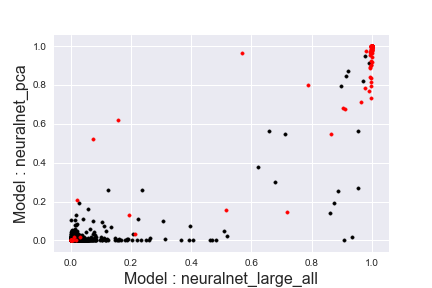

In [211]:
fig,ax = py.subplots()
xlabel = 'neuralnet_large_all'
ylabel = 'neuralnet_pca'
test_zero = class_test[class_test==0].index
xx = predicted_probabilities.loc[test_zero,xlabel]
yy = predicted_probabilities.loc[test_zero,ylabel]
ax.scatter(xx,yy,color='k',s=12)
test_zero = class_test[class_test==1].index
xx = predicted_probabilities.loc[test_zero,xlabel]
yy = predicted_probabilities.loc[test_zero,ylabel]
ax.scatter(xx,yy,color='r',s=12)
ax.set_xlabel('Model : {:s}'.format(xlabel),fontsize=16)
ax.set_ylabel('Model : {:s}'.format(ylabel),fontsize=16)

# Clustering

In [261]:
clustering = sklearn.cluster.SpectralClustering(n_clusters=2)
frauds = dataset_selected[dataset_selected['Class']==1]
clusters = clustering.fit_predict(frauds.drop('Class',axis=1))

/Users/tiagobatalhao/anaconda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [264]:
sum(clusters)

10

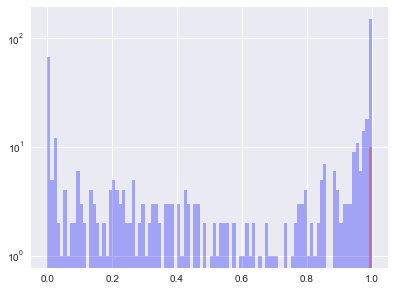

In [266]:
index_clusterA = frauds.index[[not bool(x) for x in clusters]]
index_clusterB = frauds.index[[bool(x) for x in clusters]]
label = 'logreg_pca'
prob_clusterA = predicted_probabilities.loc[index_clusterA,label]
prob_clusterB = predicted_probabilities.loc[index_clusterB,label]
fig = py.figure(figsize=(6.4,1*4.8))
ax = fig.add_subplot(111)
hist_y,hist_x,_ = ax.hist(prob_clusterA,bins=100,range=(0,1),color='b',alpha=0.3)
ax.set_yscale('linear')
# ax = fig.add_subplot(212)
hist_y,hist_x,_ = ax.hist(prob_clusterB,bins=100,range=(0,1),color='r',alpha=0.3)
ax.set_yscale('log')

In [255]:
predicted_probabilities.loc[index_clusterA]

,logreg_pca,logreg_all,naivebayes_pca,naivebayes_all,tree_gini_pca,tree_gini_all,tree_entropy_pca,tree_entropy_all,svc_linear_all,svc_general_all,neuralnet_pca,neuralnet_all,neuralnet_large_pca,neuralnet_large_all,neuralnet_large_pcanew,neuralnet_large_allnew
541,0.275930,0.602721,9.999342e-01,1.000000e+00,1.0,1.0,1.0,1.0,0,1,0.927996,0.842666,0.894130,0.986870,0.979027,0.878089
623,0.003588,0.001999,2.544033e-12,6.973390e-12,0.0,0.0,0.0,0.0,0,0,0.001832,0.000455,0.002661,0.017632,0.036347,0.009787
4920,0.021009,0.028920,1.000000e+00,1.000000e+00,0.0,0.0,0.0,0.0,0,0,0.148890,0.016106,0.132851,0.716835,0.013264,0.026839
6108,0.954397,0.996119,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.0,1,1,0.910198,0.935176,0.800842,0.999153,0.739279,0.793918
6329,0.190113,0.203562,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.0,0,0,0.494602,0.657337,0.281728,0.218465,0.405196,0.520031
6331,0.997200,0.999858,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.0,1,1,0.998621,0.999714,0.992042,0.999830,0.999890,0.998749
6334,0.996207,0.999717,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.0,1,1,0.998928,0.999937,0.994227,0.999747,0.999916,0.998862
6336,0.978451,0.997603,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.0,1,1,0.998673,0.999770,0.995312,0.999257,0.999740,0.997026
6338,0.978046,0.997422,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.0,1,1,0.998413,0.999910,0.993994,0.998961,0.999785,0.997558
6427,0.797663,0.969306,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.0,1,1,0.950576,0.990417,0.854572,0.996275,0.985943,0.984655


# Visualizations

<IPython.core.display.Javascript object>


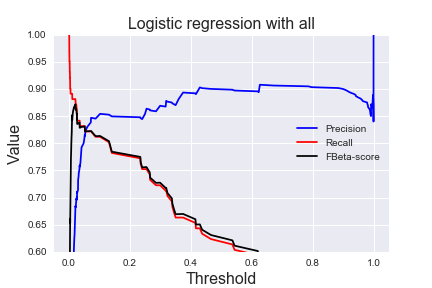

Optimal FBeta score : 0.872
Precision at optimal point: 0.685
Recall at optimal point: 0.881
Threshold at optimal point: 0.021


In [293]:
label = 'logreg_pca'
beta = 5
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,predicted_probabilities[label].loc[class_test.index])
prt = py.array([(x,y,z) for x,y,z in zip(precision,recall,threshold) if z>0.00 and z<1])
fig = py.figure()
ax = fig.add_subplot(111)
ax.plot(prt.T[2],prt.T[0],'b-',label='Precision')
ax.plot(prt.T[2],prt.T[1],'r-',label='Recall')
fbeta = [((1+beta**2)*x[0]*x[1]/(beta**2*x[0]+x[1])) for x in prt]
ax.plot(prt.T[2],fbeta,'k-',label='FBeta-score')
ax.set_xlabel('Threshold',fontsize=16)
ax.set_ylabel('Value',fontsize=16)
ax.set_title('Logistic regression with all',fontsize=16)
ax.legend(loc='center right')
ax.set_ylim(0.6,1.0)
print('Optimal FBeta score : {:5.3f}'.format(max(fbeta)))
print('Precision at optimal point: {:5.3f}'.format(precision[fbeta.index(max(fbeta))]))
print('Recall at optimal point: {:5.3f}'.format(recall[fbeta.index(max(fbeta))]))
print('Threshold at optimal point: {:5.3f}'.format(threshold[fbeta.index(max(fbeta))]))

<IPython.core.display.Javascript object>


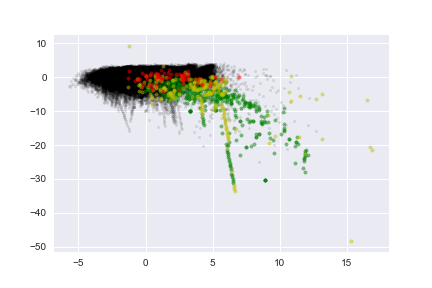

In [301]:
%matplotlib notebook
model_label,model_threshold = 'logreg_pca',0.021
variableA = 'V4'
variableB = 'V3'

fig = py.figure()
ax = fig.add_subplot(111)
classes = pd.DataFrame(index=dataset.index)
classes['True'] = dataset['Class'].apply(bool)
classes['Predicted'] = predicted_probabilities[model_label] > model_threshold
colors = ['k','b','r','g']
alpha = [0.1,1,1,1]
# for class_true in [False,True]:
#     for class_predict in [False,True]:

indices = classes[(classes['True']==False) & (classes['Predicted']==False)].index
ds = dataset_selected.loc[indices]
ax.scatter(ds[variableA],ds[variableB],color='k',alpha=0.1,s=6)
indices = classes[(classes['True']==True) & (classes['Predicted']==True)].index
ds = dataset_selected.loc[indices]
ax.scatter(ds[variableA],ds[variableB],color='g',alpha=0.5,s=12,label='TP')
indices = classes[(classes['True']==False) & (classes['Predicted']==True)].index
ds = dataset_selected.loc[indices]
ax.scatter(ds[variableA],ds[variableB],color='y',alpha=0.5,s=12,label='FP')
indices = classes[(classes['True']==True) & (classes['Predicted']==False)].index
ds = dataset_selected.loc[indices]
ax.scatter(ds[variableA],ds[variableB],color='r',alpha=0.5,s=12,label='FN')


In [277]:
sum(classes['True'])

492

In [278]:
sum(classes['Predicted'])

636